# Application: Galaxy Classification

Galaxies come in [many different shapes](https://en.wikipedia.org/wiki/Galaxy_morphological_classification).  Large surveys can images 100,000s or millions of galaxies, and we want to be able to classify them into types.  We can use a neural network for this.

We will use the [Galaxy10 DECaLS dataset](https://astronn.readthedocs.io/en/latest/galaxy10.html) [(Leung & Bovy 2024)](https://zenodo.org/records/10845026),
which contains 17736 images of galaxies, each 256x256 pixels and 3 colors (g, r, and z bands), classified into 10 different categories.  It also provides RA and dec, redshift, and pixel scale---we'll ignore those.

You can get the dataset from Zenodo: [Galaxy10_DECals.h5](https://zenodo.org/records/10845026/files/Galaxy10_DECals.h5)

This is an [HDF5](https://www.hdfgroup.org/solutions/hdf5/) file---this is a self-describing binary format that is popular in scientific computing.  We can read it in python using the
[h5py library](https://www.h5py.org/).

```{warning}
This is a big dataset (~2.5 GB), so we need to be careful with memory.  As we'll see below,
we'll keep the data in the original `uint8` form for as long as possible, converting it
to a float a galaxy at a time, as needed.
```

```{note}
There is no separate training and test set, so we need to partition the 17736 images ourselves.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

If we look at the dataset, we can see the fields:

In [2]:
ds = h5py.File("Galaxy10_DECals.h5")
ds.keys()

<KeysViewHDF5 ['ans', 'dec', 'images', 'pxscale', 'ra', 'redshift']>

let's look at the answers

In [3]:
ans = np.array(ds["ans"])
ans.shape, ans.dtype

((17736,), dtype('uint8'))

We see that there are 17736 records, stored as a NumPy array.

```{important}
The galaxies are stored in the dataset sorted by type.  So all of the "disturbed galaxies" (type `0`) come first, then the "merging galaxies", ...
```

## Exploring the data

Let's define descriptive names for the galaxy types

In [4]:
galaxy_types = {0: "disturbed galaxies",
                1: "merging galaxies",
                2: "round smooth galaxies",
                3: "in-between round smooth galaxies",
                4: "cigar shaped smooth galaxies",
                5: "barred spiral galaxies",
                6: "unbarred tight spiral galaxies",
                7: "unbarred loose spiral galaxies",
                8: "edge-on galaxies without bulge",
                9: "edge-on galaxies with bulge"}

We'll also create a simple class (`Galaxy`) to manage the data.

Here we pass in the image data for a single galaxy as a NumPy `uint8` array---the same datatype used in the file.  This class will convert it to a single precision floating-point array, scaled to fall between 0 and 1.  We also convert the answer to a categorical datatype (and array of length 10).

In [5]:
class Galaxy:
    def __init__(self, data, answer, *, index=-1):
        self.data = np.array(data, dtype=np.float32) / 255.0
        self.answer = answer

        self.index = index

    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        ax.imshow(self.data, interpolation="nearest")
        ax.text(0.025, 0.95, f"answer: {self.answer}",
                color="white", transform=ax.transAxes)

    def validate(self, prediction):
        """check if a categorical prediction matches the answer"""
        return np.argmax(prediction) == self.answer

Now let's find the first example of each type and plot it

In [6]:
images = ds["images"]
images.dtype

dtype('uint8')

```{note}
This doesn't read in the data.  It just provides a `Dataset` type that can be used
to access the data, so we can get a single galaxy at a time.
```

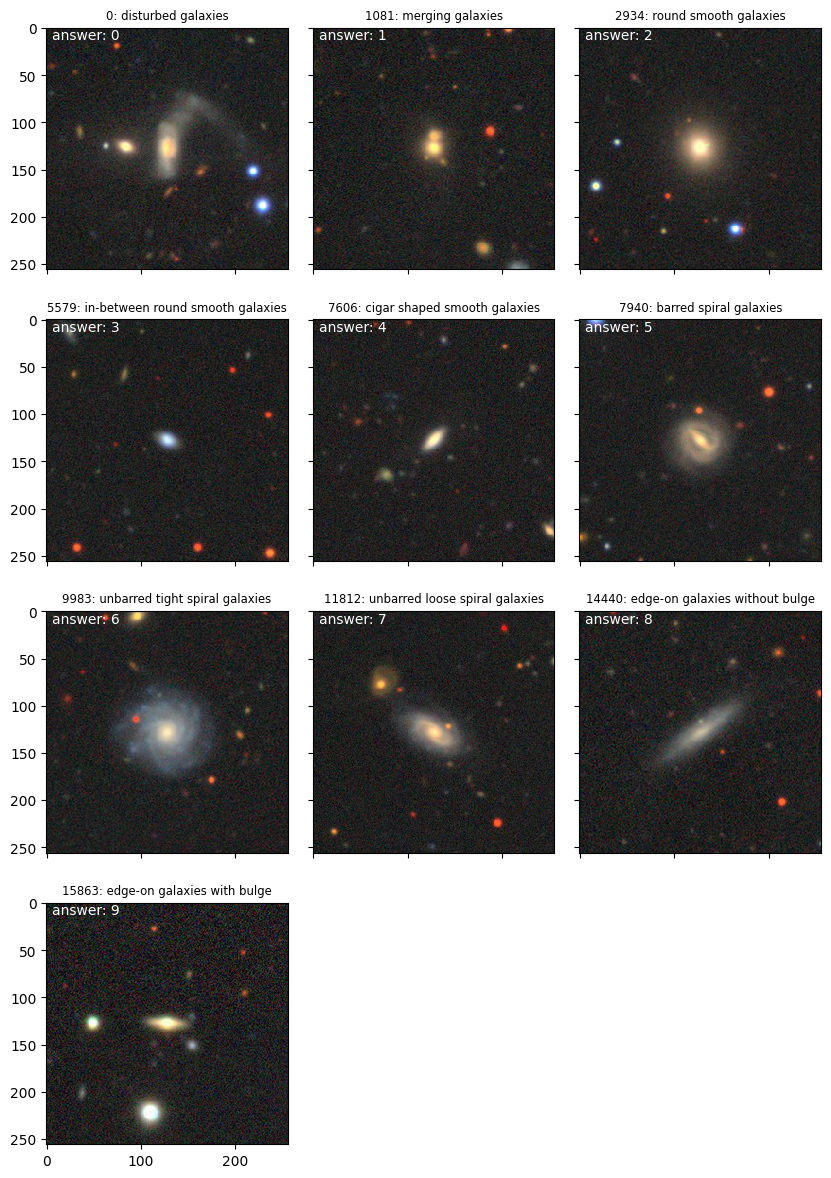

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure()
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 3),
                 axes_pad=(0.25, 0.5))

for i in range(10):
    idx = np.where(ans == i)[0][0]
    g = Galaxy(images[idx, :, :, :], ans[idx])
    g.plot(ax=grid[i])
    grid[i].set_title(f"{idx}: {galaxy_types[i]}", fontsize="small")

grid[10].set_axis_off()
grid[11].set_axis_off()
fig.set_size_inches(10, 15)

## A data manager class

We'll create a class to manage access to the data.  This will do the following:

* open the file and store the handles to access the data
* partition the data into test and training sets
* provide a means to shuffle the data
* provide a [generator](https://wiki.python.org/moin/Generators) to get the next dataset (either training or test)
* allow us to coarsen the images to a reduced resolution to make the training easier.

```{important}
Since each class of galaxy is stored together in the file, we will want to
randomize the order before splitting into training and testing sets.
```

```{tip}
We will read all of the data once, which will take about 3.5 GB of memory.  It is kept
as a `uint8` until needed.
```

In [8]:
from keras.utils import to_categorical

In [9]:
class DataManager:
    def __init__(self, partition=0.8,
                 batch_size=32,
                 datafile="Galaxy10_DECals.h5",
                 coarsen=1):
        """manage access to the data

        partition: fraction that should be training
        datafile: name of the hdf5 file with the data
        coarsen: reduce the number of pixels by this factor
        """

        self.ds = h5py.File(datafile)
        self.ans = np.array(self.ds["ans"])
        self.images = np.array(self.ds["images"])

        self.coarsen = coarsen

        self.batch_size = batch_size
        
        N = len(self.ans)

        # create a set of indices for the galaxies and randomize
        self.indices = np.arange(N, dtype=np.uint32)
        self.rng = np.random.default_rng()
        self.rng.shuffle(self.indices)

        # partition into training and test sets
        # these indices will always refer to the index in the original
        # unsplit dataset
        n_cut = int(partition * N)

        # we want this to be a multiple of the batch size
        n_cut -= n_cut % self.batch_size

        self.training_indices = self.indices[0:n_cut]
        self.test_indices = self.indices[n_cut:N]

        self.n_training = len(self.training_indices)
        self.n_test = len(self.test_indices)

        # shape information
        self.input_shape = len(self._get_galaxy(0).reshape(-1))

        # number of batches for the training
        self.n_batches = n_cut // self.batch_size
    
    def _get_galaxy(self, index):
        """return a numpy array containing a single galaxy image, coarsened
        if necessary by averaging"""
        _tmp = self.images[index, :, :, :]
        if self.coarsen > 1:
            _tmp = np.mean(_tmp.reshape(_tmp.shape[0]//self.coarsen, self.coarsen,
                                        _tmp.shape[1]//self.coarsen, self.coarsen,
                                        _tmp.shape[2]), axis=(1, 3))
        return _tmp

    def training_images(self):
        self.reset_training()
        for idx in self.training_indices:
            yield Galaxy(self._get_galaxy(idx), self.ans[idx], index=idx)

    def batched_training_generator(self):
        while True:
            self.reset_training()
            batch_x = []
            batch_y = []
            for idx in self.training_indices:
                g = Galaxy(self._get_galaxy(idx), self.ans[idx], index=idx)
                batch_x.append(g.data.reshape(-1))
                batch_y.append(to_categorical(g.answer, 10))

                if len(batch_x) == self.batch_size:
                    yield (np.array(batch_x), np.array(batch_y))
                    batch_x = []
                    batch_y = []
    
    def reset_training(self):
        """prepare for the next epoch: shuffle the training data and
        reset the index to point to the start"""
        self.rng.shuffle(self.training_indices)

    def testing_images(self):
        for idx in self.test_indices:
            yield Galaxy(self._get_galaxy(idx), self.ans[idx], index=idx)

````{tip}
The `training_images()` and `testing_images()` are generators (like `range()`), so we can iterate like:

```python
d = DataManager()
for g in d.training_images():
    # do stuff with g
```

and `g` is only converted to 32-bit float as needed.
````

We can now work with the data as follows.  Here we create a `DataManager` that will coarsen the images by a factor of 4 (so they will be 64x64 pixels with 3 colors).

In [10]:
d = DataManager(coarsen=4, batch_size=128)

we can see how many images there are in the training and test sets

In [11]:
d.n_training, d.n_test

(14080, 3656)

In [12]:
14176/32

443.0

In [13]:
d.n_batches

110

In [14]:
d.input_shape

12288

We can then get loop over training galaxies and look at them (we'll break after 5):

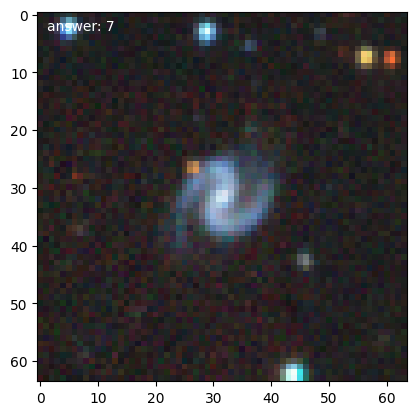

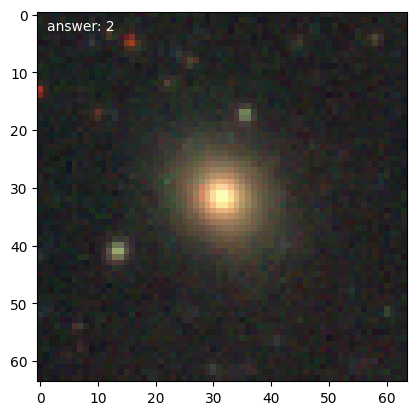

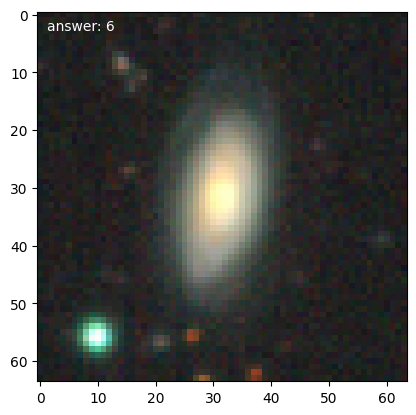

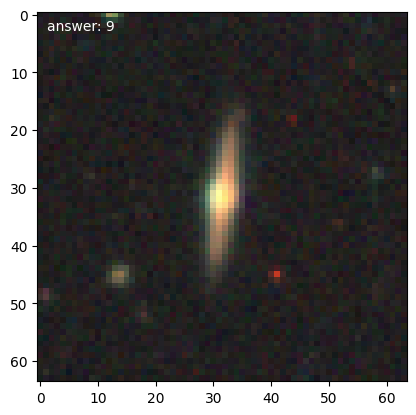

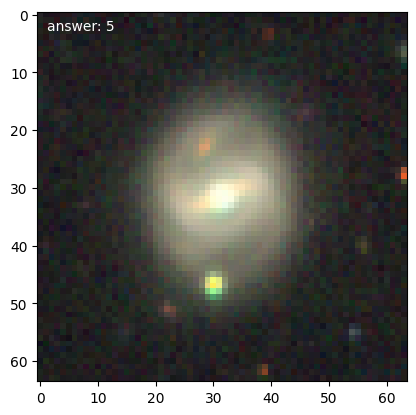

In [15]:
for n, g in enumerate(d.training_images()):
    g.plot()
    if n == 4:
        break

```{note}
Each time we access the generator it randomizes the galaxies in the training set.
```

In [16]:
for n, (bx, by) in enumerate(d.batched_training_generator()):
    print(by)
    if n == 2:
        break

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


## Implementing our neural network

In [17]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation

In [18]:
model = Sequential()
model.add(Input(shape=(d.input_shape,)))
model.add(Dense(250, activation="relu"))
model.add(Dropout(0.4))
#model.add(Dense(500, activation="relu"))
#model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

In [19]:
from keras.optimizers import Adam

rms = Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=rms, metrics=['accuracy'])

In [20]:
model.fit(d.batched_training_generator(),
          batch_size=d.batch_size,
          steps_per_epoch=d.n_batches,
          epochs=60)

Epoch 1/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 267ms/step - accuracy: 0.1562 - loss: 2.4500
Epoch 2/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 267ms/step - accuracy: 0.2294 - loss: 2.0331
Epoch 3/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 266ms/step - accuracy: 0.2546 - loss: 1.9839
Epoch 4/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 264ms/step - accuracy: 0.2564 - loss: 1.9531
Epoch 5/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 263ms/step - accuracy: 0.2675 - loss: 1.9326
Epoch 6/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 263ms/step - accuracy: 0.2654 - loss: 1.9072
Epoch 7/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 272ms/step - accuracy: 0.2759 - loss: 1.8996
Epoch 8/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 275ms/step - accuracy: 0.2798 - loss: 1.8836
Epoch 9/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 270ms/step - accuracy: 0.2827 - loss: 1.8752
Epoch 10/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 274ms/step - accuracy: 0.2781 - loss: 1.8846
Epoch 11/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 269ms/step - accuracy: 0.2938 - loss: 1.8632
Epoch 12/60
110/110

In [21]:
for n, (x, y) in enumerate(d.training_generator()):
    print(y)
    if n == 20:
        break

AttributeError: 'DataManager' object has no attribute 'training_generator'